# First Draft

## Libraries

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

## Function Declaration

In [2]:
def find_largest_safe_zone(img, left_pct, right_pct, top_pct, bottom_pct, faces):
    # Load the image
    img_height, img_width = img.shape[:2]

    # Calculate the boundary limits
    left_bound = int(left_pct * img_width)
    right_bound = int((1 - right_pct) * img_width)
    top_bound = int(top_pct * img_height)
    bottom_bound = int((1 - bottom_pct) * img_height)

    # Initialize the binary matrix based on some discretization
    # Note: For simplicity, let's assume we're working with the full pixel grid
    binary_matrix = np.ones((img_height, img_width), dtype=int)
    
    # Mark areas outside the allowed boundaries as occupied (0)
    binary_matrix[:, :left_bound] = 0
    binary_matrix[:, right_bound:] = 0
    binary_matrix[:top_bound, :] = 0
    binary_matrix[bottom_bound:, :] = 0

    # Mark areas occupied by faces as occupied (0)
    for x, y, w, h in faces:
        binary_matrix[y:y+h, x:x+w] = 0

    return binary_matrix

In [3]:
def maximal_rectangle(matrix):
    if not matrix or not matrix[0]:
        return 0, 0, 0, 0  # Return x, y, width, height with area 0 for empty matrix

    n, m = len(matrix), len(matrix[0])
    height = [0] * m
    left = [0] * m
    right = [m] * m
    max_rectangle = (0, 0, 0, 0)  # x, y, width, height as initial max
    max_area = 0

    for i in range(n):
        cur_left, cur_right = 0, m
        # Update height, left, and right for each column in the current row
        for j in range(m):
            if matrix[i][j] == '1':
                height[j] += 1
                left[j] = max(left[j], cur_left)
            else:
                height[j] = 0
                left[j] = 0
                cur_left = j + 1

            # Update right for the current row from right to left
            if matrix[i][m - 1 - j] == '1':
                right[m - 1 - j] = min(right[m - 1 - j], cur_right)
            else:
                right[m - 1 - j] = m
                cur_right = m - 1 - j

        # Compute and update maximum area rectangle for each column
        for j in range(m):
            width = right[j] - left[j]
            area = width * height[j]
            if area > max_area:
                max_rectangle = (left[j], i - height[j] + 1, width, height[j])
                max_area = area

    return max_rectangle  # Return x, y, width, height of the maximum rectangle

In [4]:
def rotate_image(frame, angle):
    (h, w) = frame.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Get the rotation matrix for the specified angle
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)

    # Perform the rotation
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the actual rotation and return the image
    rotated_frame = cv2.warpAffine(frame, M, (nW, nH))

    return rotated_frame, M

In [23]:
class FaceOrientationCounter:
    def __init__(self):
        # Initialize counters for each orientation
        self.counters = {0: 0, 90: 0, 270: 0}
        
    def update(self, angle, faces_detected):
        # Increase the counter for the current angle if faces are detected
        if faces_detected > 0:
            self.counters[angle] = (faces_detected + self.counters[angle])/2
            
        # Decrease the counters slightly each time to favor recent observations
        for ang in self.counters:
            if ang != angle:
                self.counters[ang] *= 0.9  # Decay factor for 'forgetting' older observations
                
    def get_preferred_orientation(self):
        # Determine the orientation with the highest counter value
        preferred_angle = max(self.counters, key=self.counters.get)
        return preferred_angle

def detect_faces_in_rotations_3(frame, face_cascade, orientation_counter=None):
    # Define the rotation angles
    rotation_angles = [0, 90, 270]
    detected_faces = dict()

    original_w, original_h = frame.shape[1], frame.shape[0]
    most_faces_detected = 0
    best_angle = 0

    for angle in rotation_angles:
        # Rotate the image
        rotated_frame, M = rotate_image(frame, angle)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(rotated_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
#         faces = face_cascade.detectMultiScale(rotated_frame)
        print(f'angle: {angle}, faces: {faces}')
        if len(faces) > most_faces_detected:
            # If more faces are detected, update the counter and the best angle
            most_faces_detected = len(faces)
            best_angle = angle
            detected_faces[angle] = [(x, y, w, h) for (x, y, w, h) in faces]
        print(f'angle: {angle}, faces: {faces}, detected_faces: {detected_faces}, best_angle: {best_angle}')
            
    # Update orientation counter if it's provided
    if orientation_counter is not None:
        orientation_counter.update(best_angle, most_faces_detected)
        best_angle = orientation_counter.get_preferred_orientation()

    # Adjust detected faces based on the best angle
    adjusted_faces = []
    if most_faces_detected > 0 and best_angle in detected_faces:
#         print(f'best_angle: {best_angle}')
        for (x, y, w, h) in detected_faces[best_angle]:
            # Calculate the inverse rotation for the detected face coordinates based on the best angle
            rotated_frame, M = rotate_image(frame, best_angle)
            inv_M = cv2.invertAffineTransform(M)
            original_coords = np.array([[x + w/2, y + h/2]], dtype=np.float32)
            original_coords = np.array([original_coords])
            # Transform back the coordinates of the center of the face
            transformed_coords = cv2.transform(original_coords, inv_M)
            ox, oy = transformed_coords[0][0]
            ox, oy = int(ox - w/2), int(oy - h/2)
            
            # Store the corrected face box
            adjusted_faces.append((ox, oy, w, h))
    
#     print(f'best_angle: {best_angle}, orientation_counter: {orientation_counter.counters}')
#     print(f'best_angle: {best_angle}')
   

    return adjusted_faces

In [6]:
def frame_checker(face_cascade, frame, orientation_counter):
    # Boundaries
    left_pct, right_pct, top_pct, bottom_pct = 0.05,  0.1, 0.05, 0.15

    # Detect faces
    faces = detect_faces_in_rotations_3(frame, face_cascade, orientation_counter)
#     faces = detect_faces_in_rotations_2(frame, face_cascade, orientation_counter)
#     faces = detect_faces_in_rotations(frame, face_cascade)
    
    # To show faces
    for face in faces:
        (x, y, w, h) = face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 3)

    # Convert image into binary array to perform find the largest safe zone
    binary_array = find_largest_safe_zone(frame, left_pct, right_pct, top_pct, bottom_pct, faces)
    array = binary_array.astype(str).tolist()
    
    result_frame = draw_safe_zone(frame, (maximal_rectangle(array)))
    
    return result_frame

In [7]:
def timer(frames_processed, start_time, fps, total_frames):
    frames_processed += 1

    # Calculate the average processing time per frame up to this point
    elapsed_time = (time.time() - start_time)
    average_time_per_frame = elapsed_time / frames_processed

    # Calculate the estimated remaining time
    remaining_frames = total_frames - frames_processed
    estimated_remaining_time = remaining_frames * average_time_per_frame
    print(f"Total frames: {total_frames}, Remaining frames: {remaining_frames}, Est. remaining time: {estimated_remaining_time:.1f} s, Total elapsed time: {elapsed_time:.1f}, FPS: {1/average_time_per_frame:.2f}")
        
    return frames_processed

In [8]:
def draw_safe_zone(image, safe_zone):
    """
    Draw a green rectangle around the safe zone.
    """
    x, y, w, h = safe_zone
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
    return image

In [9]:
def add_safe_zone_to_video(input_video_path, output_video_path):
    
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    
    # Obtain video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Define the codec and create a VideoWriter object to write the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' if you face issues with 'mp4v'
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    frames_processed = 0
    start_time = time.time()
    
    face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')
    
    # Initialize the counter object outside of your frame processing loop
    orientation_counter = FaceOrientationCounter()
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Add the green frame into the frame
        edited_frame = frame_checker(face_cascade, frame, orientation_counter)
        
        # Write the frame with the safe zone to the output video
        out.write(edited_frame)
        
        # Frame counter/ timer (optional)
        frames_processed = timer(frames_processed, start_time, fps, total_frames)
        
        # Break the loop if 'q' is pressed (for real-time viewing)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release everything when job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

## Function Caller

### Trimmed

In [289]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4_trimmed.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

Total frames: 107, Remaining frames: 106, Est. remaining time: 116.1 s, Total elapsed time: 1.1, FPS: 0.91
Total frames: 107, Remaining frames: 105, Est. remaining time: 108.4 s, Total elapsed time: 2.1, FPS: 0.97
Total frames: 107, Remaining frames: 104, Est. remaining time: 105.3 s, Total elapsed time: 3.0, FPS: 0.99
Total frames: 107, Remaining frames: 103, Est. remaining time: 102.9 s, Total elapsed time: 4.0, FPS: 1.00
Total frames: 107, Remaining frames: 102, Est. remaining time: 100.8 s, Total elapsed time: 4.9, FPS: 1.01
Total frames: 107, Remaining frames: 101, Est. remaining time: 99.4 s, Total elapsed time: 5.9, FPS: 1.02
Total frames: 107, Remaining frames: 100, Est. remaining time: 99.2 s, Total elapsed time: 6.9, FPS: 1.01
Total frames: 107, Remaining frames: 99, Est. remaining time: 97.8 s, Total elapsed time: 7.9, FPS: 1.01
Total frames: 107, Remaining frames: 98, Est. remaining time: 96.5 s, Total elapsed time: 8.9, FPS: 1.02
Total frames: 107, Remaining frames: 97, Es

Total frames: 107, Remaining frames: 28, Est. remaining time: 26.3 s, Total elapsed time: 74.1, FPS: 1.07
Total frames: 107, Remaining frames: 27, Est. remaining time: 25.3 s, Total elapsed time: 75.0, FPS: 1.07
Total frames: 107, Remaining frames: 26, Est. remaining time: 24.4 s, Total elapsed time: 75.9, FPS: 1.07
Total frames: 107, Remaining frames: 25, Est. remaining time: 23.4 s, Total elapsed time: 76.9, FPS: 1.07
Total frames: 107, Remaining frames: 24, Est. remaining time: 22.5 s, Total elapsed time: 77.8, FPS: 1.07
Total frames: 107, Remaining frames: 23, Est. remaining time: 21.6 s, Total elapsed time: 78.8, FPS: 1.07
Total frames: 107, Remaining frames: 22, Est. remaining time: 20.7 s, Total elapsed time: 79.8, FPS: 1.07
Total frames: 107, Remaining frames: 21, Est. remaining time: 19.7 s, Total elapsed time: 80.7, FPS: 1.07
Total frames: 107, Remaining frames: 20, Est. remaining time: 18.8 s, Total elapsed time: 81.7, FPS: 1.06
Total frames: 107, Remaining frames: 19, Est. 

In [256]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4_90_trimmed.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

angle: 0, faces: [[1150  242   65   65]
 [1129  722   79   79]], detected_faces: {0: [(1150, 242, 65, 65), (1129, 722, 79, 79)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(1150, 242, 65, 65), (1129, 722, 79, 79)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(1150, 242, 65, 65), (1129, 722, 79, 79)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 107, Remaining frames: 106, Est. remaining time: 129.9 s, Total elapsed time: 1.2, FPS: 0.82
angle: 0, faces: [[1132  721   79   79]], detected_faces: {0: [(1132, 721, 79, 79)]}, best_angle: 0
angle: 90, faces: [[366 918  71  71]], detected_faces: {0: [(1132, 721, 79, 79)]}, best_angle: 0
angle: 270, faces: [[ 31 725  81  81]], detected_faces: {0: [(1132, 721, 79, 79)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 107, Remaining frames: 105, Est. remaining time: 119.1 s, Total elapsed time: 2.3, FPS: 0.88
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[366 919  68  

Total frames: 107, Remaining frames: 86, Est. remaining time: 88.3 s, Total elapsed time: 21.6, FPS: 0.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[782 844 168 168]], detected_faces: {270: [(782, 844, 168, 168)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 107, Remaining frames: 85, Est. remaining time: 87.2 s, Total elapsed time: 22.6, FPS: 0.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[782 850 155 155]], detected_faces: {270: [(782, 850, 155, 155)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 107, Remaining frames: 84, Est. remaining time: 86.1 s, Total elapsed time: 23.6, FPS: 0.98
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
best_angle: 270
Total 

Total frames: 107, Remaining frames: 62, Est. remaining time: 62.9 s, Total elapsed time: 45.6, FPS: 0.99
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[475 814  52  52]], detected_faces: {270: [(475, 814, 52, 52)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 107, Remaining frames: 61, Est. remaining time: 61.9 s, Total elapsed time: 46.6, FPS: 0.99
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[473 810  54  54]], detected_faces: {270: [(473, 810, 54, 54)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 107, Remaining frames: 60, Est. remaining time: 60.8 s, Total elapsed time: 47.7, FPS: 0.99
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[468 808  54  54]
 [762 851 123 123]], detected_faces: {270: [(

Total frames: 107, Remaining frames: 43, Est. remaining time: 43.9 s, Total elapsed time: 65.4, FPS: 0.98
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 434 1037   67   67]
 [ 530 1017   79   79]], detected_faces: {90: [(434, 1037, 67, 67), (530, 1017, 79, 79)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(434, 1037, 67, 67), (530, 1017, 79, 79)]}, best_angle: 90
best_angle: 90
best_angle: 90
Total frames: 107, Remaining frames: 42, Est. remaining time: 42.9 s, Total elapsed time: 66.4, FPS: 0.98
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 431 1040   68   68]
 [ 528 1021   80   80]], detected_faces: {90: [(431, 1040, 68, 68), (528, 1021, 80, 80)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(431, 1040, 68, 68), (528, 1021, 80, 80)]}, best_angle: 90
best_angle: 90
best_angle: 90
Total frames: 107, Remaining frames: 41, Est. remaining time: 41.9 s, Total elapsed time: 67.4, FPS: 0.98
angle: 0, 

Total frames: 107, Remaining frames: 27, Est. remaining time: 27.8 s, Total elapsed time: 82.5, FPS: 0.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 250  993   40   40]
 [ 537 1064   96   96]
 [ 421 1089   78   78]], detected_faces: {90: [(250, 993, 40, 40), (537, 1064, 96, 96), (421, 1089, 78, 78)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(250, 993, 40, 40), (537, 1064, 96, 96), (421, 1089, 78, 78)]}, best_angle: 90
best_angle: 90
best_angle: 90
Total frames: 107, Remaining frames: 26, Est. remaining time: 26.8 s, Total elapsed time: 83.5, FPS: 0.97
angle: 0, faces: [[868 236  71  71]], detected_faces: {0: [(868, 236, 71, 71)]}, best_angle: 0
angle: 90, faces: [[ 248  994   40   40]
 [ 422 1090   82   82]
 [ 539 1066   98   98]], detected_faces: {0: [(868, 236, 71, 71)], 90: [(248, 994, 40, 40), (422, 1090, 82, 82), (539, 1066, 98, 98)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {0: [(868, 236, 71, 71)], 90: [(248, 994

best_angle: 90
Total frames: 107, Remaining frames: 14, Est. remaining time: 14.5 s, Total elapsed time: 96.1, FPS: 0.97
angle: 0, faces: [[1133  334   52   52]], detected_faces: {0: [(1133, 334, 52, 52)]}, best_angle: 0
angle: 90, faces: [[ 294  610  484  484]
 [ 238 1027   47   47]
 [ 585 1115  116  116]
 [ 444 1145   95   95]
 [ 202  742  155  155]], detected_faces: {0: [(1133, 334, 52, 52)], 90: [(294, 610, 484, 484), (238, 1027, 47, 47), (585, 1115, 116, 116), (444, 1145, 95, 95), (202, 742, 155, 155)]}, best_angle: 90
angle: 270, faces: [[564 658  49  49]], detected_faces: {0: [(1133, 334, 52, 52)], 90: [(294, 610, 484, 484), (238, 1027, 47, 47), (585, 1115, 116, 116), (444, 1145, 95, 95), (202, 742, 155, 155)]}, best_angle: 90
best_angle: 90
best_angle: 90
Total frames: 107, Remaining frames: 13, Est. remaining time: 13.4 s, Total elapsed time: 97.1, FPS: 0.97
angle: 0, faces: [[1132  334   54   54]
 [ 663  539   53   53]], detected_faces: {0: [(1132, 334, 54, 54), (663, 539, 53

In [257]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4_270_trimmed.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[353 915  77  77]], detected_faces: {270: [(353, 915, 77, 77)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 119, Remaining frames: 118, Est. remaining time: 137.7 s, Total elapsed time: 1.2, FPS: 0.86
angle: 0, faces: [[ 682   28   96   96]
 [1199  755  122  122]], detected_faces: {0: [(682, 28, 96, 96), (1199, 755, 122, 122)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(682, 28, 96, 96), (1199, 755, 122, 122)]}, best_angle: 0
angle: 270, faces: [[355 915  76  76]], detected_faces: {0: [(682, 28, 96, 96), (1199, 755, 122, 122)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 119, Remaining frames: 117, Est. remaining time: 129.9 s, Total elapsed time: 2.2, FPS: 0.90
angle: 0, faces: [[682  26  98  98]], detected_faces: {0: [(682, 26, 98, 98)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(682, 26, 98,

Total frames: 119, Remaining frames: 98, Est. remaining time: 102.5 s, Total elapsed time: 22.0, FPS: 0.96
angle: 0, faces: [[969 846  58  58]], detected_faces: {0: [(969, 846, 58, 58)]}, best_angle: 0
angle: 90, faces: [[784 839 176 176]], detected_faces: {0: [(969, 846, 58, 58)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(969, 846, 58, 58)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 119, Remaining frames: 97, Est. remaining time: 101.3 s, Total elapsed time: 23.0, FPS: 0.96
angle: 0, faces: [[970 844  57  57]], detected_faces: {0: [(970, 844, 57, 57)]}, best_angle: 0
angle: 90, faces: [[783 838 183 183]], detected_faces: {0: [(970, 844, 57, 57)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(970, 844, 57, 57)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 119, Remaining frames: 96, Est. remaining time: 100.1 s, Total elapsed time: 24.0, FPS: 0.96
angle: 0, faces: [[969 842  59  59]], detected_faces: {0: [(969, 842, 59, 59)]}, 

Total frames: 119, Remaining frames: 78, Est. remaining time: 81.3 s, Total elapsed time: 42.7, FPS: 0.96
angle: 0, faces: [[969 822  58  58]], detected_faces: {0: [(969, 822, 58, 58)]}, best_angle: 0
angle: 90, faces: [[ 727 1104   65   65]], detected_faces: {0: [(969, 822, 58, 58)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(969, 822, 58, 58)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 119, Remaining frames: 77, Est. remaining time: 80.2 s, Total elapsed time: 43.7, FPS: 0.96
angle: 0, faces: [[968 820  59  59]], detected_faces: {0: [(968, 820, 59, 59)]}, best_angle: 0
angle: 90, faces: [[506 445 354 354]
 [777 853 144 144]], detected_faces: {0: [(968, 820, 59, 59)], 90: [(506, 445, 354, 354), (777, 853, 144, 144)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {0: [(968, 820, 59, 59)], 90: [(506, 445, 354, 354), (777, 853, 144, 144)]}, best_angle: 90
best_angle: 90
best_angle: 90
Total frames: 119, Remaining frames: 76, Est. remaining time: 7

Total frames: 119, Remaining frames: 58, Est. remaining time: 60.2 s, Total elapsed time: 63.3, FPS: 0.96
angle: 0, faces: [[1012  480   65   65]
 [ 980  789   61   61]], detected_faces: {0: [(1012, 480, 65, 65), (980, 789, 61, 61)]}, best_angle: 0
angle: 90, faces: [[461 801  55  55]], detected_faces: {0: [(1012, 480, 65, 65), (980, 789, 61, 61)]}, best_angle: 0
angle: 270, faces: [[ 447 1026   60   60]
 [ 534 1009   71   71]], detected_faces: {0: [(1012, 480, 65, 65), (980, 789, 61, 61)]}, best_angle: 0
best_angle: 0
best_angle: 0
Total frames: 119, Remaining frames: 57, Est. remaining time: 59.2 s, Total elapsed time: 64.4, FPS: 0.96
angle: 0, faces: [[980 789  61  61]], detected_faces: {0: [(980, 789, 61, 61)]}, best_angle: 0
angle: 90, faces: [[458 798  57  57]], detected_faces: {0: [(980, 789, 61, 61)]}, best_angle: 0
angle: 270, faces: [[ 448 1027   60   60]
 [ 534 1011   70   70]], detected_faces: {0: [(980, 789, 61, 61)], 270: [(448, 1027, 60, 60), (534, 1011, 70, 70)]}, best_

Total frames: 119, Remaining frames: 40, Est. remaining time: 41.5 s, Total elapsed time: 81.9, FPS: 0.96
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[ 423 1058   70   70]
 [ 525 1037   85   85]], detected_faces: {270: [(423, 1058, 70, 70), (525, 1037, 85, 85)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 119, Remaining frames: 39, Est. remaining time: 40.4 s, Total elapsed time: 83.0, FPS: 0.96
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[ 270  977   36   36]
 [ 423 1063   69   69]
 [ 525 1042   85   85]], detected_faces: {270: [(270, 977, 36, 36), (423, 1063, 69, 69), (525, 1042, 85, 85)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 119, Remaining frames: 38, Est. remaining time: 39.4 s, Total elapsed time: 84.0, FPS: 0.96
angle: 0, faces: (), detected_faces: {}, best_angle: 

Total frames: 119, Remaining frames: 22, Est. remaining time: 22.8 s, Total elapsed time: 100.6, FPS: 0.96
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[831 677  77  77]], detected_faces: {90: [(831, 677, 77, 77)]}, best_angle: 90
angle: 270, faces: [[ 244 1006   44   44]
 [ 435 1114   86   86]
 [ 560 1085  108  108]
 [ 228  760  131  131]], detected_faces: {90: [(831, 677, 77, 77)], 270: [(244, 1006, 44, 44), (435, 1114, 86, 86), (560, 1085, 108, 108), (228, 760, 131, 131)]}, best_angle: 270
best_angle: 270
best_angle: 270
Total frames: 119, Remaining frames: 21, Est. remaining time: 21.8 s, Total elapsed time: 101.7, FPS: 0.96
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[ 243 1008   47   47]
 [ 222  757  139  139]
 [ 436 1119   88   88]
 [ 566 1091  108  108]], detected_faces: {270: [(243, 1008, 47, 47), (222, 757, 139, 139), (436, 1119, 88, 88), (566, 1091, 108, 108)]}

In [297]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_1_trimmed.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 238, Est. remaining time: 28.5 s, Total elapsed time: 0.1, FPS: 8.34
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 237, Est. remaining time: 22.5 s, Total elapsed time: 0.2, FPS: 10.53
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 236, Est. remaining time: 19.9 s, Total elapsed time: 0.3, FPS: 11.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total fr

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 208, Est. remaining time: 14.4 s, Total elapsed time: 2.1, FPS: 14.46
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 207, Est. remaining time: 14.3 s, Total elapsed time: 2.2, FPS: 14.48
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 206, Est. remaining time: 14.2 s, Total elapsed time: 2.3, FPS: 14.50
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total f

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 178, Est. remaining time: 12.0 s, Total elapsed time: 4.1, FPS: 14.84
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 177, Est. remaining time: 11.9 s, Total elapsed time: 4.2, FPS: 14.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 176, Est. remaining time: 11.8 s, Total elapsed time: 4.2, FPS: 14.86
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 175, Est. remaining time: 11.8 s, Total elapsed time: 4.3, FPS: 14.87
angle: 0, f

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 147, Est. remaining time: 9.8 s, Total elapsed time: 6.1, FPS: 15.00
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 146, Est. remaining time: 9.7 s, Total elapsed time: 6.2, FPS: 15.01
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 145, Est. remaining time: 9.7 s, Total elapsed time: 6.3, FPS: 15.01
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total fram

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 116, Est. remaining time: 7.7 s, Total elapsed time: 8.2, FPS: 15.07
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 115, Est. remaining time: 7.6 s, Total elapsed time: 8.2, FPS: 15.08
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 114, Est. remaining time: 7.6 s, Total elapsed time: 8.3, FPS: 15.08
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 113, Est. remaining time: 7.5 s, Total elapsed time: 8.4, FPS: 15.08
angle: 0, faces

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 85, Est. remaining time: 5.6 s, Total elapsed time: 10.2, FPS: 15.12
angle: 0, faces: [[93 82 49 49]], detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
Total frames: 239, Remaining frames: 84, Est. remaining time: 5.6 s, Total elapsed time: 10.2, FPS: 15.13
angle: 0, faces: [[93 83 48 48]], detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
Total frames: 239, Remaining frames: 83, Est. remaining time: 5.5 s, Total elapsed time: 10.3, FPS: 15.13
angle: 0, faces: (), detec

Total frames: 239, Remaining frames: 54, Est. remaining time: 3.6 s, Total elapsed time: 12.2, FPS: 15.17
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 53, Est. remaining time: 3.5 s, Total elapsed time: 12.3, FPS: 15.17
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 52, Est. remaining time: 3.4 s, Total elapsed time: 12.3, FPS: 15.17
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 51, Est. remaining time: 3.4 s, Total elapsed time: 12.4, FPS: 15.18
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces:

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 22, Est. remaining time: 1.4 s, Total elapsed time: 14.3, FPS: 15.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 239, Remaining frames: 21, Est. remaining time: 1.4 s, Total elapsed time: 14.3, FPS: 15.21


### Original


In [285]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

Total frames: 416, Remaining frames: 415, Est. remaining time: 418.2 s, Total elapsed time: 1.0, FPS: 0.99
Total frames: 416, Remaining frames: 414, Est. remaining time: 409.9 s, Total elapsed time: 2.0, FPS: 1.01
Total frames: 416, Remaining frames: 413, Est. remaining time: 402.9 s, Total elapsed time: 2.9, FPS: 1.02
Total frames: 416, Remaining frames: 412, Est. remaining time: 397.7 s, Total elapsed time: 3.9, FPS: 1.04
Total frames: 416, Remaining frames: 411, Est. remaining time: 393.5 s, Total elapsed time: 4.8, FPS: 1.04
Total frames: 416, Remaining frames: 410, Est. remaining time: 390.7 s, Total elapsed time: 5.7, FPS: 1.05
Total frames: 416, Remaining frames: 409, Est. remaining time: 388.6 s, Total elapsed time: 6.7, FPS: 1.05
Total frames: 416, Remaining frames: 408, Est. remaining time: 386.4 s, Total elapsed time: 7.6, FPS: 1.06
Total frames: 416, Remaining frames: 407, Est. remaining time: 385.1 s, Total elapsed time: 8.5, FPS: 1.06
Total frames: 416, Remaining frames: 

Total frames: 416, Remaining frames: 339, Est. remaining time: 319.1 s, Total elapsed time: 72.5, FPS: 1.06
Total frames: 416, Remaining frames: 338, Est. remaining time: 318.1 s, Total elapsed time: 73.4, FPS: 1.06
Total frames: 416, Remaining frames: 337, Est. remaining time: 317.0 s, Total elapsed time: 74.3, FPS: 1.06
Total frames: 416, Remaining frames: 336, Est. remaining time: 316.0 s, Total elapsed time: 75.2, FPS: 1.06
Total frames: 416, Remaining frames: 335, Est. remaining time: 315.0 s, Total elapsed time: 76.2, FPS: 1.06
Total frames: 416, Remaining frames: 334, Est. remaining time: 313.9 s, Total elapsed time: 77.1, FPS: 1.06
Total frames: 416, Remaining frames: 333, Est. remaining time: 312.9 s, Total elapsed time: 78.0, FPS: 1.06
Total frames: 416, Remaining frames: 332, Est. remaining time: 311.8 s, Total elapsed time: 78.9, FPS: 1.06
Total frames: 416, Remaining frames: 331, Est. remaining time: 310.8 s, Total elapsed time: 79.8, FPS: 1.06
Total frames: 416, Remaining

Total frames: 416, Remaining frames: 263, Est. remaining time: 245.8 s, Total elapsed time: 143.0, FPS: 1.07
Total frames: 416, Remaining frames: 262, Est. remaining time: 244.9 s, Total elapsed time: 143.9, FPS: 1.07
Total frames: 416, Remaining frames: 261, Est. remaining time: 244.0 s, Total elapsed time: 144.9, FPS: 1.07
Total frames: 416, Remaining frames: 260, Est. remaining time: 243.1 s, Total elapsed time: 145.9, FPS: 1.07
Total frames: 416, Remaining frames: 259, Est. remaining time: 242.2 s, Total elapsed time: 146.8, FPS: 1.07
Total frames: 416, Remaining frames: 258, Est. remaining time: 241.3 s, Total elapsed time: 147.8, FPS: 1.07
Total frames: 416, Remaining frames: 257, Est. remaining time: 240.4 s, Total elapsed time: 148.7, FPS: 1.07
Total frames: 416, Remaining frames: 256, Est. remaining time: 239.4 s, Total elapsed time: 149.6, FPS: 1.07
Total frames: 416, Remaining frames: 255, Est. remaining time: 238.5 s, Total elapsed time: 150.6, FPS: 1.07
Total frames: 416, 

Total frames: 416, Remaining frames: 187, Est. remaining time: 174.7 s, Total elapsed time: 214.0, FPS: 1.07
Total frames: 416, Remaining frames: 186, Est. remaining time: 173.8 s, Total elapsed time: 214.9, FPS: 1.07
Total frames: 416, Remaining frames: 185, Est. remaining time: 172.8 s, Total elapsed time: 215.8, FPS: 1.07
Total frames: 416, Remaining frames: 184, Est. remaining time: 171.9 s, Total elapsed time: 216.7, FPS: 1.07
Total frames: 416, Remaining frames: 183, Est. remaining time: 170.9 s, Total elapsed time: 217.6, FPS: 1.07
Total frames: 416, Remaining frames: 182, Est. remaining time: 170.0 s, Total elapsed time: 218.6, FPS: 1.07
Total frames: 416, Remaining frames: 181, Est. remaining time: 169.0 s, Total elapsed time: 219.5, FPS: 1.07
Total frames: 416, Remaining frames: 180, Est. remaining time: 168.1 s, Total elapsed time: 220.4, FPS: 1.07
Total frames: 416, Remaining frames: 179, Est. remaining time: 167.2 s, Total elapsed time: 221.3, FPS: 1.07
Total frames: 416, 

Total frames: 416, Remaining frames: 111, Est. remaining time: 103.3 s, Total elapsed time: 283.9, FPS: 1.07
Total frames: 416, Remaining frames: 110, Est. remaining time: 102.4 s, Total elapsed time: 284.8, FPS: 1.07
Total frames: 416, Remaining frames: 109, Est. remaining time: 101.4 s, Total elapsed time: 285.7, FPS: 1.07
Total frames: 416, Remaining frames: 108, Est. remaining time: 100.5 s, Total elapsed time: 286.6, FPS: 1.07
Total frames: 416, Remaining frames: 107, Est. remaining time: 99.6 s, Total elapsed time: 287.5, FPS: 1.07
Total frames: 416, Remaining frames: 106, Est. remaining time: 98.6 s, Total elapsed time: 288.5, FPS: 1.07
Total frames: 416, Remaining frames: 105, Est. remaining time: 97.7 s, Total elapsed time: 289.4, FPS: 1.07
Total frames: 416, Remaining frames: 104, Est. remaining time: 96.8 s, Total elapsed time: 290.3, FPS: 1.07
Total frames: 416, Remaining frames: 103, Est. remaining time: 95.8 s, Total elapsed time: 291.2, FPS: 1.07
Total frames: 416, Remai

Total frames: 416, Remaining frames: 34, Est. remaining time: 31.6 s, Total elapsed time: 355.3, FPS: 1.08
Total frames: 416, Remaining frames: 33, Est. remaining time: 30.7 s, Total elapsed time: 356.2, FPS: 1.08
Total frames: 416, Remaining frames: 32, Est. remaining time: 29.8 s, Total elapsed time: 357.1, FPS: 1.08
Total frames: 416, Remaining frames: 31, Est. remaining time: 28.8 s, Total elapsed time: 358.0, FPS: 1.08
Total frames: 416, Remaining frames: 30, Est. remaining time: 27.9 s, Total elapsed time: 359.0, FPS: 1.08
Total frames: 416, Remaining frames: 29, Est. remaining time: 27.0 s, Total elapsed time: 359.9, FPS: 1.08
Total frames: 416, Remaining frames: 28, Est. remaining time: 26.0 s, Total elapsed time: 360.8, FPS: 1.08
Total frames: 416, Remaining frames: 27, Est. remaining time: 25.1 s, Total elapsed time: 361.7, FPS: 1.08
Total frames: 416, Remaining frames: 26, Est. remaining time: 24.2 s, Total elapsed time: 362.6, FPS: 1.08
Total frames: 416, Remaining frames: 

In [286]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4_90.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

Total frames: 416, Remaining frames: 415, Est. remaining time: 415.2 s, Total elapsed time: 1.0, FPS: 1.00
Total frames: 416, Remaining frames: 414, Est. remaining time: 403.4 s, Total elapsed time: 1.9, FPS: 1.03
Total frames: 416, Remaining frames: 413, Est. remaining time: 402.2 s, Total elapsed time: 2.9, FPS: 1.03
Total frames: 416, Remaining frames: 412, Est. remaining time: 397.7 s, Total elapsed time: 3.9, FPS: 1.04
Total frames: 416, Remaining frames: 411, Est. remaining time: 394.4 s, Total elapsed time: 4.8, FPS: 1.04
Total frames: 416, Remaining frames: 410, Est. remaining time: 393.6 s, Total elapsed time: 5.8, FPS: 1.04
Total frames: 416, Remaining frames: 409, Est. remaining time: 393.2 s, Total elapsed time: 6.7, FPS: 1.04
Total frames: 416, Remaining frames: 408, Est. remaining time: 390.6 s, Total elapsed time: 7.7, FPS: 1.04
Total frames: 416, Remaining frames: 407, Est. remaining time: 389.3 s, Total elapsed time: 8.6, FPS: 1.05
Total frames: 416, Remaining frames: 

Total frames: 416, Remaining frames: 339, Est. remaining time: 318.2 s, Total elapsed time: 72.3, FPS: 1.07
Total frames: 416, Remaining frames: 338, Est. remaining time: 317.2 s, Total elapsed time: 73.2, FPS: 1.07
Total frames: 416, Remaining frames: 337, Est. remaining time: 316.2 s, Total elapsed time: 74.1, FPS: 1.07
Total frames: 416, Remaining frames: 336, Est. remaining time: 315.2 s, Total elapsed time: 75.0, FPS: 1.07
Total frames: 416, Remaining frames: 335, Est. remaining time: 314.2 s, Total elapsed time: 76.0, FPS: 1.07
Total frames: 416, Remaining frames: 334, Est. remaining time: 313.2 s, Total elapsed time: 76.9, FPS: 1.07
Total frames: 416, Remaining frames: 333, Est. remaining time: 312.1 s, Total elapsed time: 77.8, FPS: 1.07
Total frames: 416, Remaining frames: 332, Est. remaining time: 311.1 s, Total elapsed time: 78.7, FPS: 1.07
Total frames: 416, Remaining frames: 331, Est. remaining time: 310.1 s, Total elapsed time: 79.6, FPS: 1.07
Total frames: 416, Remaining

Total frames: 416, Remaining frames: 263, Est. remaining time: 247.9 s, Total elapsed time: 144.2, FPS: 1.06
Total frames: 416, Remaining frames: 262, Est. remaining time: 247.1 s, Total elapsed time: 145.2, FPS: 1.06
Total frames: 416, Remaining frames: 261, Est. remaining time: 246.2 s, Total elapsed time: 146.2, FPS: 1.06
Total frames: 416, Remaining frames: 260, Est. remaining time: 245.3 s, Total elapsed time: 147.2, FPS: 1.06
Total frames: 416, Remaining frames: 259, Est. remaining time: 244.4 s, Total elapsed time: 148.2, FPS: 1.06
Total frames: 416, Remaining frames: 258, Est. remaining time: 243.5 s, Total elapsed time: 149.1, FPS: 1.06
Total frames: 416, Remaining frames: 257, Est. remaining time: 242.6 s, Total elapsed time: 150.1, FPS: 1.06
Total frames: 416, Remaining frames: 256, Est. remaining time: 241.7 s, Total elapsed time: 151.0, FPS: 1.06
Total frames: 416, Remaining frames: 255, Est. remaining time: 240.7 s, Total elapsed time: 152.0, FPS: 1.06
Total frames: 416, 

Total frames: 416, Remaining frames: 187, Est. remaining time: 177.4 s, Total elapsed time: 217.2, FPS: 1.05
Total frames: 416, Remaining frames: 186, Est. remaining time: 176.4 s, Total elapsed time: 218.1, FPS: 1.05
Total frames: 416, Remaining frames: 185, Est. remaining time: 175.4 s, Total elapsed time: 219.1, FPS: 1.05
Total frames: 416, Remaining frames: 184, Est. remaining time: 174.5 s, Total elapsed time: 220.0, FPS: 1.05
Total frames: 416, Remaining frames: 183, Est. remaining time: 173.5 s, Total elapsed time: 220.9, FPS: 1.05
Total frames: 416, Remaining frames: 182, Est. remaining time: 172.6 s, Total elapsed time: 221.9, FPS: 1.05
Total frames: 416, Remaining frames: 181, Est. remaining time: 171.6 s, Total elapsed time: 222.8, FPS: 1.05
Total frames: 416, Remaining frames: 180, Est. remaining time: 170.7 s, Total elapsed time: 223.7, FPS: 1.05
Total frames: 416, Remaining frames: 179, Est. remaining time: 169.7 s, Total elapsed time: 224.7, FPS: 1.05
Total frames: 416, 

Total frames: 416, Remaining frames: 111, Est. remaining time: 108.5 s, Total elapsed time: 298.0, FPS: 1.02
Total frames: 416, Remaining frames: 110, Est. remaining time: 107.5 s, Total elapsed time: 299.1, FPS: 1.02
Total frames: 416, Remaining frames: 109, Est. remaining time: 106.6 s, Total elapsed time: 300.1, FPS: 1.02
Total frames: 416, Remaining frames: 108, Est. remaining time: 105.6 s, Total elapsed time: 301.2, FPS: 1.02
Total frames: 416, Remaining frames: 107, Est. remaining time: 104.6 s, Total elapsed time: 302.2, FPS: 1.02
Total frames: 416, Remaining frames: 106, Est. remaining time: 103.7 s, Total elapsed time: 303.2, FPS: 1.02
Total frames: 416, Remaining frames: 105, Est. remaining time: 102.7 s, Total elapsed time: 304.3, FPS: 1.02
Total frames: 416, Remaining frames: 104, Est. remaining time: 101.8 s, Total elapsed time: 305.3, FPS: 1.02
Total frames: 416, Remaining frames: 103, Est. remaining time: 100.8 s, Total elapsed time: 306.3, FPS: 1.02
Total frames: 416, 

Total frames: 416, Remaining frames: 34, Est. remaining time: 33.7 s, Total elapsed time: 378.9, FPS: 1.01
Total frames: 416, Remaining frames: 33, Est. remaining time: 32.7 s, Total elapsed time: 379.9, FPS: 1.01
Total frames: 416, Remaining frames: 32, Est. remaining time: 31.7 s, Total elapsed time: 381.0, FPS: 1.01
Total frames: 416, Remaining frames: 31, Est. remaining time: 30.8 s, Total elapsed time: 382.0, FPS: 1.01
Total frames: 416, Remaining frames: 30, Est. remaining time: 29.8 s, Total elapsed time: 383.0, FPS: 1.01
Total frames: 416, Remaining frames: 29, Est. remaining time: 28.8 s, Total elapsed time: 384.1, FPS: 1.01
Total frames: 416, Remaining frames: 28, Est. remaining time: 27.8 s, Total elapsed time: 385.1, FPS: 1.01
Total frames: 416, Remaining frames: 27, Est. remaining time: 26.8 s, Total elapsed time: 386.1, FPS: 1.01
Total frames: 416, Remaining frames: 26, Est. remaining time: 25.8 s, Total elapsed time: 387.2, FPS: 1.01
Total frames: 416, Remaining frames: 

In [287]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_4_270.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

Total frames: 416, Remaining frames: 415, Est. remaining time: 463.4 s, Total elapsed time: 1.1, FPS: 0.90
Total frames: 416, Remaining frames: 414, Est. remaining time: 452.8 s, Total elapsed time: 2.2, FPS: 0.91
Total frames: 416, Remaining frames: 413, Est. remaining time: 454.2 s, Total elapsed time: 3.3, FPS: 0.91
Total frames: 416, Remaining frames: 412, Est. remaining time: 447.9 s, Total elapsed time: 4.3, FPS: 0.92
Total frames: 416, Remaining frames: 411, Est. remaining time: 444.5 s, Total elapsed time: 5.4, FPS: 0.92
Total frames: 416, Remaining frames: 410, Est. remaining time: 440.5 s, Total elapsed time: 6.4, FPS: 0.93
Total frames: 416, Remaining frames: 409, Est. remaining time: 438.1 s, Total elapsed time: 7.5, FPS: 0.93
Total frames: 416, Remaining frames: 408, Est. remaining time: 435.8 s, Total elapsed time: 8.5, FPS: 0.94
Total frames: 416, Remaining frames: 407, Est. remaining time: 433.9 s, Total elapsed time: 9.6, FPS: 0.94
Total frames: 416, Remaining frames: 

Total frames: 416, Remaining frames: 339, Est. remaining time: 356.3 s, Total elapsed time: 80.9, FPS: 0.95
Total frames: 416, Remaining frames: 338, Est. remaining time: 355.2 s, Total elapsed time: 82.0, FPS: 0.95
Total frames: 416, Remaining frames: 337, Est. remaining time: 354.1 s, Total elapsed time: 83.0, FPS: 0.95
Total frames: 416, Remaining frames: 336, Est. remaining time: 353.0 s, Total elapsed time: 84.0, FPS: 0.95
Total frames: 416, Remaining frames: 335, Est. remaining time: 351.9 s, Total elapsed time: 85.1, FPS: 0.95
Total frames: 416, Remaining frames: 334, Est. remaining time: 350.8 s, Total elapsed time: 86.1, FPS: 0.95
Total frames: 416, Remaining frames: 333, Est. remaining time: 349.7 s, Total elapsed time: 87.2, FPS: 0.95
Total frames: 416, Remaining frames: 332, Est. remaining time: 348.5 s, Total elapsed time: 88.2, FPS: 0.95
Total frames: 416, Remaining frames: 331, Est. remaining time: 347.4 s, Total elapsed time: 89.2, FPS: 0.95
Total frames: 416, Remaining

Total frames: 416, Remaining frames: 263, Est. remaining time: 275.0 s, Total elapsed time: 160.0, FPS: 0.96
Total frames: 416, Remaining frames: 262, Est. remaining time: 274.0 s, Total elapsed time: 161.0, FPS: 0.96
Total frames: 416, Remaining frames: 261, Est. remaining time: 272.9 s, Total elapsed time: 162.1, FPS: 0.96
Total frames: 416, Remaining frames: 260, Est. remaining time: 271.9 s, Total elapsed time: 163.1, FPS: 0.96
Total frames: 416, Remaining frames: 259, Est. remaining time: 270.9 s, Total elapsed time: 164.2, FPS: 0.96
Total frames: 416, Remaining frames: 258, Est. remaining time: 269.8 s, Total elapsed time: 165.3, FPS: 0.96
Total frames: 416, Remaining frames: 257, Est. remaining time: 268.8 s, Total elapsed time: 166.3, FPS: 0.96
Total frames: 416, Remaining frames: 256, Est. remaining time: 267.8 s, Total elapsed time: 167.4, FPS: 0.96
Total frames: 416, Remaining frames: 255, Est. remaining time: 266.7 s, Total elapsed time: 168.4, FPS: 0.96
Total frames: 416, 

Total frames: 416, Remaining frames: 187, Est. remaining time: 195.8 s, Total elapsed time: 239.8, FPS: 0.95
Total frames: 416, Remaining frames: 186, Est. remaining time: 194.8 s, Total elapsed time: 240.8, FPS: 0.96
Total frames: 416, Remaining frames: 185, Est. remaining time: 193.7 s, Total elapsed time: 241.9, FPS: 0.96
Total frames: 416, Remaining frames: 184, Est. remaining time: 192.7 s, Total elapsed time: 242.9, FPS: 0.95
Total frames: 416, Remaining frames: 183, Est. remaining time: 191.6 s, Total elapsed time: 244.0, FPS: 0.96
Total frames: 416, Remaining frames: 182, Est. remaining time: 190.6 s, Total elapsed time: 245.0, FPS: 0.96
Total frames: 416, Remaining frames: 181, Est. remaining time: 189.5 s, Total elapsed time: 246.1, FPS: 0.96
Total frames: 416, Remaining frames: 180, Est. remaining time: 188.5 s, Total elapsed time: 247.1, FPS: 0.96
Total frames: 416, Remaining frames: 179, Est. remaining time: 187.4 s, Total elapsed time: 248.1, FPS: 0.96
Total frames: 416, 

Total frames: 416, Remaining frames: 111, Est. remaining time: 116.1 s, Total elapsed time: 318.9, FPS: 0.96
Total frames: 416, Remaining frames: 110, Est. remaining time: 115.0 s, Total elapsed time: 320.0, FPS: 0.96
Total frames: 416, Remaining frames: 109, Est. remaining time: 114.0 s, Total elapsed time: 321.0, FPS: 0.96
Total frames: 416, Remaining frames: 108, Est. remaining time: 112.9 s, Total elapsed time: 322.1, FPS: 0.96
Total frames: 416, Remaining frames: 107, Est. remaining time: 111.9 s, Total elapsed time: 323.1, FPS: 0.96
Total frames: 416, Remaining frames: 106, Est. remaining time: 110.8 s, Total elapsed time: 324.1, FPS: 0.96
Total frames: 416, Remaining frames: 105, Est. remaining time: 109.8 s, Total elapsed time: 325.2, FPS: 0.96
Total frames: 416, Remaining frames: 104, Est. remaining time: 108.7 s, Total elapsed time: 326.2, FPS: 0.96
Total frames: 416, Remaining frames: 103, Est. remaining time: 107.7 s, Total elapsed time: 327.3, FPS: 0.96
Total frames: 416, 

Total frames: 416, Remaining frames: 34, Est. remaining time: 35.6 s, Total elapsed time: 399.5, FPS: 0.96
Total frames: 416, Remaining frames: 33, Est. remaining time: 34.5 s, Total elapsed time: 400.6, FPS: 0.96
Total frames: 416, Remaining frames: 32, Est. remaining time: 33.5 s, Total elapsed time: 401.7, FPS: 0.96
Total frames: 416, Remaining frames: 31, Est. remaining time: 32.4 s, Total elapsed time: 402.7, FPS: 0.96
Total frames: 416, Remaining frames: 30, Est. remaining time: 31.4 s, Total elapsed time: 403.7, FPS: 0.96
Total frames: 416, Remaining frames: 29, Est. remaining time: 30.3 s, Total elapsed time: 404.8, FPS: 0.96
Total frames: 416, Remaining frames: 28, Est. remaining time: 29.3 s, Total elapsed time: 405.8, FPS: 0.96
Total frames: 416, Remaining frames: 27, Est. remaining time: 28.2 s, Total elapsed time: 406.8, FPS: 0.96
Total frames: 416, Remaining frames: 26, Est. remaining time: 27.2 s, Total elapsed time: 407.9, FPS: 0.96
Total frames: 416, Remaining frames: 

In [295]:
# Example usage
ori_path = 'samples/'
input_video = 'video_test_1.mp4'
output_sign = '[Output] ' 
input_video_path = ori_path + input_video
output_video_path = ori_path + output_sign + input_video

add_safe_zone_to_video(input_video_path, output_video_path)

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2288, Est. remaining time: 294.8 s, Total elapsed time: 0.1, FPS: 7.76
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2287, Est. remaining time: 226.0 s, Total elapsed time: 0.2, FPS: 10.12
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2286, Est. remaining time: 202.5 s, Total elapsed time: 0.3, FPS: 11.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0

Total frames: 2289, Remaining frames: 2259, Est. remaining time: 160.3 s, Total elapsed time: 2.1, FPS: 14.10
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2258, Est. remaining time: 160.1 s, Total elapsed time: 2.2, FPS: 14.10
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2257, Est. remaining time: 159.9 s, Total elapsed time: 2.3, FPS: 14.11
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2256, Est. remaining time: 159.6 s, Total elapsed time: 2.3, FPS: 14.13
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 2229, Est. remaining time: 156.2 s, Total elapsed time: 4.2, FPS: 14.27
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2228, Est. remaining time: 156.0 s, Total elapsed time: 4.3, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2227, Est. remaining time: 155.9 s, Total elapsed time: 4.3, FPS: 14.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2226, Est. remaining time: 155.7 s, Total elapsed time: 4.4, FPS: 14.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 2199, Est. remaining time: 152.6 s, Total elapsed time: 6.2, FPS: 14.41
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2198, Est. remaining time: 152.5 s, Total elapsed time: 6.3, FPS: 14.41
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2197, Est. remaining time: 152.4 s, Total elapsed time: 6.4, FPS: 14.42
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2196, Est. remaining time: 152.3 s, Total elapsed time: 6.4, FPS: 14.42
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 2169, Est. remaining time: 149.7 s, Total elapsed time: 8.3, FPS: 14.48
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2168, Est. remaining time: 149.7 s, Total elapsed time: 8.4, FPS: 14.49
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2167, Est. remaining time: 149.6 s, Total elapsed time: 8.4, FPS: 14.49
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2166, Est. remaining time: 149.5 s, Total elapsed time: 8.5, FPS: 14.49
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 2139, Est. remaining time: 147.2 s, Total elapsed time: 10.3, FPS: 14.53
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2138, Est. remaining time: 147.1 s, Total elapsed time: 10.4, FPS: 14.53
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2137, Est. remaining time: 147.0 s, Total elapsed time: 10.5, FPS: 14.54
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2136, Est. remaining time: 146.9 s, Total elapsed time: 10.5, FPS: 14.54
angle: 0, faces: (), detected_faces: {}, best_angle:

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2108, Est. remaining time: 144.9 s, Total elapsed time: 12.4, FPS: 14.55
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2107, Est. remaining time: 144.8 s, Total elapsed time: 12.5, FPS: 14.55
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2106, Est. remaining time: 144.7 s, Total elapsed time: 12.6, FPS: 14.55
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2078, Est. remaining time: 142.7 s, Total elapsed time: 14.5, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2077, Est. remaining time: 142.6 s, Total elapsed time: 14.6, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2076, Est. remaining time: 142.5 s, Total elapsed time: 14.6, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2048, Est. remaining time: 140.6 s, Total elapsed time: 16.5, FPS: 14.57
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2047, Est. remaining time: 140.5 s, Total elapsed time: 16.6, FPS: 14.57
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2046, Est. remaining time: 140.4 s, Total elapsed time: 16.7, FPS: 14.57
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2018, Est. remaining time: 138.4 s, Total elapsed time: 18.6, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2017, Est. remaining time: 138.3 s, Total elapsed time: 18.7, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 2016, Est. remaining time: 138.3 s, Total elapsed time: 18.7, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1988, Est. remaining time: 136.2 s, Total elapsed time: 20.6, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1987, Est. remaining time: 136.1 s, Total elapsed time: 20.7, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1986, Est. remaining time: 136.1 s, Total elapsed time: 20.8, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1985, Est. r

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1958, Est. remaining time: 134.2 s, Total elapsed time: 22.7, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1957, Est. remaining time: 134.2 s, Total elapsed time: 22.8, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1956, Est. remaining time: 134.1 s, Total elapsed time: 22.8, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1928, Est. remaining time: 132.2 s, Total elapsed time: 24.8, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1927, Est. remaining time: 132.1 s, Total elapsed time: 24.8, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1926, Est. remaining time: 132.1 s, Total elapsed time: 24.9, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1898, Est. remaining time: 130.2 s, Total elapsed time: 26.8, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1897, Est. remaining time: 130.1 s, Total elapsed time: 26.9, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1896, Est. remaining time: 130.1 s, Total elapsed time: 27.0, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1868, Est. remaining time: 128.1 s, Total elapsed time: 28.9, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1867, Est. remaining time: 128.1 s, Total elapsed time: 28.9, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1866, Est. remaining time: 128.0 s, Total elapsed time: 29.0, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1838, Est. remaining time: 126.1 s, Total elapsed time: 30.9, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1837, Est. remaining time: 126.0 s, Total elapsed time: 31.0, FPS: 14.57
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1836, Est. remaining time: 126.0 s, Total elapsed time: 31.1, FPS: 14.57
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1808, Est. remaining time: 124.1 s, Total elapsed time: 33.0, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1807, Est. remaining time: 124.1 s, Total elapsed time: 33.1, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1806, Est. remaining time: 124.0 s, Total elapsed time: 33.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1778, Est. remaining time: 122.1 s, Total elapsed time: 35.1, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1777, Est. remaining time: 122.0 s, Total elapsed time: 35.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1776, Est. remaining time: 121.9 s, Total elapsed time: 35.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1748, Est. remaining time: 120.0 s, Total elapsed time: 37.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1747, Est. remaining time: 120.0 s, Total elapsed time: 37.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1746, Est. remaining time: 119.9 s, Total elapsed time: 37.3, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 82 120 128 128]], detected_faces: {90: [(82, 120, 128, 128)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(82, 120, 128, 128)]}, best_angle: 90
Total frames: 2289, Remaining frames: 1718, Est. remaining time: 118.0 s, Total elapsed time: 39.2, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1717, Est. remaining time: 117.9 s, Total elapsed time: 39.3, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1716, Est. remaining time: 117.9 s, Total elapsed time: 39.4, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1688, Est. remaining time: 116.0 s, Total elapsed time: 41.3, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1687, Est. remaining time: 115.9 s, Total elapsed time: 41.3, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1686, Est. remaining time: 115.8 s, Total elapsed time: 41.4, FPS: 14.56
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angl

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1656, Est. remaining time: 113.6 s, Total elapsed time: 43.4, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1655, Est. remaining time: 113.5 s, Total elapsed time: 43.5, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1654, Est. remaining time: 113.4 s, Total elapsed time: 43.5, FPS: 14.58
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1653, Est. remaining time: 113.3 s, Total elapsed time: 43.6, FPS: 1

Total frames: 2289, Remaining frames: 1625, Est. remaining time: 111.3 s, Total elapsed time: 45.5, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1624, Est. remaining time: 111.3 s, Total elapsed time: 45.6, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1623, Est. remaining time: 111.3 s, Total elapsed time: 45.7, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1622, Est. remaining time: 111.2 s, Total elapsed time: 45.7, FPS: 14.59
angle: 0, faces: (), detected_faces: {}, best_angle:

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1595, Est. remaining time: 109.2 s, Total elapsed time: 47.5, FPS: 14.61
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1594, Est. remaining time: 109.1 s, Total elapsed time: 47.6, FPS: 14.61
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1593, Est. remaining time: 109.1 s, Total elapsed time: 47.6, FPS: 14.61
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1592, Est. r

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1564, Est. remaining time: 107.0 s, Total elapsed time: 49.6, FPS: 14.62
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1563, Est. remaining time: 106.9 s, Total elapsed time: 49.7, FPS: 14.62
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1562, Est. remaining time: 106.8 s, Total elapsed time: 49.7, FPS: 14.62
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1561, Est. r

Total frames: 2289, Remaining frames: 1534, Est. remaining time: 108.2 s, Total elapsed time: 53.2, FPS: 14.18
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1533, Est. remaining time: 108.2 s, Total elapsed time: 53.4, FPS: 14.16
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1532, Est. remaining time: 108.4 s, Total elapsed time: 53.6, FPS: 14.13
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1531, Est. remaining time: 108.5 s, Total elapsed time: 53.7, FPS: 14.11
angle: 0, faces: (), detected_faces: {}, best_angle:

Total frames: 2289, Remaining frames: 1504, Est. remaining time: 108.6 s, Total elapsed time: 56.7, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1503, Est. remaining time: 108.5 s, Total elapsed time: 56.8, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1502, Est. remaining time: 108.5 s, Total elapsed time: 56.8, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1501, Est. remaining time: 108.4 s, Total elapsed time: 56.9, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle:

Total frames: 2289, Remaining frames: 1474, Est. remaining time: 106.4 s, Total elapsed time: 58.8, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1473, Est. remaining time: 106.3 s, Total elapsed time: 58.9, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1472, Est. remaining time: 106.3 s, Total elapsed time: 59.0, FPS: 13.85
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1471, Est. remaining time: 106.2 s, Total elapsed time: 59.0, FPS: 13.86
angle: 0, faces: (), detected_faces: {}, best_angle:

Total frames: 2289, Remaining frames: 1442, Est. remaining time: 104.4 s, Total elapsed time: 61.3, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1441, Est. remaining time: 104.3 s, Total elapsed time: 61.4, FPS: 13.81
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1440, Est. remaining time: 104.2 s, Total elapsed time: 61.5, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1439, Est. remaining time: 104.2 s, Total elapsed time: 61.5, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle:

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1412, Est. remaining time: 102.2 s, Total elapsed time: 63.5, FPS: 13.81
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1411, Est. remaining time: 102.2 s, Total elapsed time: 63.6, FPS: 13.80
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1410, Est. remaining time: 102.1 s, Total elapsed time: 63.7, FPS: 13.80
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1409, Est. remaining time: 102.1 s, Total elapsed time: 63.7, FPS: 1

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1382, Est. remaining time: 100.0 s, Total elapsed time: 65.6, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1381, Est. remaining time: 99.9 s, Total elapsed time: 65.7, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1380, Est. remaining time: 99.8 s, Total elapsed time: 65.8, FPS: 13.82
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle:

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1351, Est. remaining time: 97.4 s, Total elapsed time: 67.6, FPS: 13.88
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1350, Est. remaining time: 97.3 s, Total elapsed time: 67.7, FPS: 13.88
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1349, Est. remaining time: 97.2 s, Total elapsed time: 67.7, FPS: 13.88
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1320, Est. remaining time: 94.8 s, Total elapsed time: 69.6, FPS: 13.93
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1319, Est. remaining time: 94.7 s, Total elapsed time: 69.6, FPS: 13.93
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1318, Est. remaining time: 94.6 s, Total elapsed time: 69.7, FPS: 13.93
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1289, Est. remaining time: 92.3 s, Total elapsed time: 71.6, FPS: 13.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1288, Est. remaining time: 92.2 s, Total elapsed time: 71.7, FPS: 13.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1287, Est. remaining time: 92.1 s, Total elapsed time: 71.7, FPS: 13.97
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

Total frames: 2289, Remaining frames: 1258, Est. remaining time: 89.8 s, Total elapsed time: 73.6, FPS: 14.01
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1257, Est. remaining time: 89.7 s, Total elapsed time: 73.6, FPS: 14.01
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1256, Est. remaining time: 89.6 s, Total elapsed time: 73.7, FPS: 14.02
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1255, Est. remaining time: 89.5 s, Total elapsed time: 73.8, FPS: 14.02
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1227, Est. remaining time: 87.3 s, Total elapsed time: 75.6, FPS: 14.05
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1226, Est. remaining time: 87.3 s, Total elapsed time: 75.7, FPS: 14.05
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1225, Est. remaining time: 87.2 s, Total elapsed time: 75.7, FPS: 14.05
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1196, Est. remaining time: 84.9 s, Total elapsed time: 77.6, FPS: 14.08
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1195, Est. remaining time: 84.9 s, Total elapsed time: 77.7, FPS: 14.08
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1194, Est. remaining time: 84.8 s, Total elapsed time: 77.8, FPS: 14.08
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

Total frames: 2289, Remaining frames: 1165, Est. remaining time: 82.5 s, Total elapsed time: 79.6, FPS: 14.12
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1164, Est. remaining time: 82.4 s, Total elapsed time: 79.7, FPS: 14.12
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1163, Est. remaining time: 82.4 s, Total elapsed time: 79.8, FPS: 14.12
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1162, Est. remaining time: 82.3 s, Total elapsed time: 79.8, FPS: 14.12
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1133, Est. remaining time: 80.1 s, Total elapsed time: 81.7, FPS: 14.15
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1132, Est. remaining time: 80.0 s, Total elapsed time: 81.7, FPS: 14.15
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1131, Est. remaining time: 79.9 s, Total elapsed time: 81.8, FPS: 14.15
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

Total frames: 2289, Remaining frames: 1102, Est. remaining time: 77.7 s, Total elapsed time: 83.7, FPS: 14.19
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1101, Est. remaining time: 77.6 s, Total elapsed time: 83.7, FPS: 14.19
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1100, Est. remaining time: 77.5 s, Total elapsed time: 83.8, FPS: 14.19
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1099, Est. remaining time: 77.5 s, Total elapsed time: 83.9, FPS: 14.19
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 1073, Est. remaining time: 75.6 s, Total elapsed time: 85.6, FPS: 14.20
angle: 0, faces: [[139 135  80  80]], detected_faces: {0: [(139, 135, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(139, 135, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(139, 135, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1072, Est. remaining time: 75.5 s, Total elapsed time: 85.7, FPS: 14.20
angle: 0, faces: [[138 135  80  80]], detected_faces: {0: [(138, 135, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(138, 135, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(138, 135, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1071, Est. remaining time: 75.4 s, Total elapsed time: 85.8, FPS: 14.20
angle: 0, faces: [[138 134  82  82]], detected_faces: {0: [(138, 134, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(138, 134, 82, 82)]}, be

angle: 90, faces: (), detected_faces: {0: [(128, 127, 81, 81)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(128, 127, 81, 81)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1048, Est. remaining time: 73.7 s, Total elapsed time: 87.3, FPS: 14.21
angle: 0, faces: [[128 125  84  84]], detected_faces: {0: [(128, 125, 84, 84)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(128, 125, 84, 84)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(128, 125, 84, 84)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1047, Est. remaining time: 73.7 s, Total elapsed time: 87.4, FPS: 14.21
angle: 0, faces: [[129 126  82  82]], detected_faces: {0: [(129, 126, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(129, 126, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(129, 126, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1046, Est. remaining time: 73.6 s, Total elapsed time: 87.4, FPS: 14.21
ang

angle: 0, faces: [[135 122  80  80]], detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1022, Est. remaining time: 71.8 s, Total elapsed time: 89.0, FPS: 14.23
angle: 0, faces: [[135 122  80  80]], detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(135, 122, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 1021, Est. remaining time: 71.8 s, Total elapsed time: 89.1, FPS: 14.23
angle: 0, faces: [[132 118  84  84]], detected_faces: {0: [(132, 118, 84, 84)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(132, 118, 84, 84)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(132, 118, 84, 84)]}, best_angle: 0
Total frames: 2289

Total frames: 2289, Remaining frames: 998, Est. remaining time: 70.1 s, Total elapsed time: 90.7, FPS: 14.24
angle: 0, faces: [[129 118  82  82]], detected_faces: {0: [(129, 118, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(129, 118, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(129, 118, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 997, Est. remaining time: 70.0 s, Total elapsed time: 90.7, FPS: 14.24
angle: 0, faces: [[130 118  81  81]], detected_faces: {0: [(130, 118, 81, 81)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(130, 118, 81, 81)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(130, 118, 81, 81)]}, best_angle: 0
Total frames: 2289, Remaining frames: 996, Est. remaining time: 70.0 s, Total elapsed time: 90.8, FPS: 14.23
angle: 0, faces: [[126 119  81  81]], detected_faces: {0: [(126, 119, 81, 81)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(126, 119, 81, 81)]}, best_

angle: 270, faces: (), detected_faces: {0: [(108, 111, 83, 83)]}, best_angle: 0
Total frames: 2289, Remaining frames: 975, Est. remaining time: 68.4 s, Total elapsed time: 92.2, FPS: 14.25
angle: 0, faces: [[108 111  83  83]], detected_faces: {0: [(108, 111, 83, 83)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(108, 111, 83, 83)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(108, 111, 83, 83)]}, best_angle: 0
Total frames: 2289, Remaining frames: 974, Est. remaining time: 68.4 s, Total elapsed time: 92.3, FPS: 14.25
angle: 0, faces: [[106 110  83  83]], detected_faces: {0: [(106, 110, 83, 83)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(106, 110, 83, 83)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(106, 110, 83, 83)]}, best_angle: 0
Total frames: 2289, Remaining frames: 973, Est. remaining time: 68.3 s, Total elapsed time: 92.4, FPS: 14.25
angle: 0, faces: [[106 110  83  83]], detected_faces: {0: [(106, 110, 83, 83)]}, best

angle: 270, faces: (), detected_faces: {0: [(89, 107, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 949, Est. remaining time: 66.5 s, Total elapsed time: 94.0, FPS: 14.26
angle: 0, faces: [[ 88 106  82  82]], detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 948, Est. remaining time: 66.5 s, Total elapsed time: 94.0, FPS: 14.26
angle: 0, faces: [[ 88 106  82  82]], detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 947, Est. remaining time: 66.4 s, Total elapsed time: 94.1, FPS: 14.26
angle: 0, faces: [[ 88 106  82  82]], detected_faces: {0: [(88, 106, 82, 82)]}, best_angle: 

Total frames: 2289, Remaining frames: 926, Est. remaining time: 64.9 s, Total elapsed time: 95.5, FPS: 14.27
angle: 0, faces: [[ 84 106  81  81]], detected_faces: {0: [(84, 106, 81, 81)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(84, 106, 81, 81)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(84, 106, 81, 81)]}, best_angle: 0
Total frames: 2289, Remaining frames: 925, Est. remaining time: 64.8 s, Total elapsed time: 95.5, FPS: 14.28
angle: 0, faces: [[ 84 106  83  83]], detected_faces: {0: [(84, 106, 83, 83)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(84, 106, 83, 83)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(84, 106, 83, 83)]}, best_angle: 0
Total frames: 2289, Remaining frames: 924, Est. remaining time: 64.7 s, Total elapsed time: 95.6, FPS: 14.28
angle: 0, faces: [[ 85 105  82  82]], detected_faces: {0: [(85, 105, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(85, 105, 82, 82)]}, best_angle: 0

angle: 270, faces: (), detected_faces: {0: [(99, 111, 84, 84)]}, best_angle: 0
Total frames: 2289, Remaining frames: 903, Est. remaining time: 63.2 s, Total elapsed time: 97.0, FPS: 14.29
angle: 0, faces: [[100 111  84  84]], detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
Total frames: 2289, Remaining frames: 902, Est. remaining time: 63.1 s, Total elapsed time: 97.1, FPS: 14.29
angle: 0, faces: [[100 111  84  84]], detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(100, 111, 84, 84)]}, best_angle: 0
Total frames: 2289, Remaining frames: 901, Est. remaining time: 63.1 s, Total elapsed time: 97.1, FPS: 14.29
angle: 0, faces: [[100 111  87  87]], detected_faces: {0: [(100, 111, 87, 87)]}, best_

Total frames: 2289, Remaining frames: 880, Est. remaining time: 61.5 s, Total elapsed time: 98.5, FPS: 14.30
angle: 0, faces: [[111 115  88  88]], detected_faces: {0: [(111, 115, 88, 88)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(111, 115, 88, 88)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(111, 115, 88, 88)]}, best_angle: 0
Total frames: 2289, Remaining frames: 879, Est. remaining time: 61.5 s, Total elapsed time: 98.6, FPS: 14.30
angle: 0, faces: [[113 114  87  87]], detected_faces: {0: [(113, 114, 87, 87)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(113, 114, 87, 87)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(113, 114, 87, 87)]}, best_angle: 0
Total frames: 2289, Remaining frames: 878, Est. remaining time: 61.4 s, Total elapsed time: 98.7, FPS: 14.30
angle: 0, faces: [[114 115  86  86]], detected_faces: {0: [(114, 115, 86, 86)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(114, 115, 86, 86)]}, best_

angle: 90, faces: (), detected_faces: {0: [(114, 116, 83, 83)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(114, 116, 83, 83)]}, best_angle: 0
Total frames: 2289, Remaining frames: 854, Est. remaining time: 59.7 s, Total elapsed time: 100.3, FPS: 14.31
angle: 0, faces: [[115 116  80  80]], detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 853, Est. remaining time: 59.6 s, Total elapsed time: 100.3, FPS: 14.31
angle: 0, faces: [[115 116  80  80]], detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(115, 116, 80, 80)]}, best_angle: 0
Total frames: 2289, Remaining frames: 852, Est. remaining time: 59.5 s, Total elapsed time: 100.4, FPS: 14.31
ang

angle: 0, faces: [[103 109  82  82]], detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 828, Est. remaining time: 57.8 s, Total elapsed time: 102.0, FPS: 14.32
angle: 0, faces: [[103 109  82  82]], detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
Total frames: 2289, Remaining frames: 827, Est. remaining time: 57.7 s, Total elapsed time: 102.1, FPS: 14.32
angle: 0, faces: [[103 109  82  82]], detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(103, 109, 82, 82)]}, best_angle: 0
Total frames: 2289

angle: 0, faces: [[106 100  85  85]], detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
Total frames: 2289, Remaining frames: 805, Est. remaining time: 56.2 s, Total elapsed time: 103.5, FPS: 14.33
angle: 0, faces: [[106 100  85  85]], detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(106, 100, 85, 85)]}, best_angle: 0
Total frames: 2289, Remaining frames: 804, Est. remaining time: 56.1 s, Total elapsed time: 103.6, FPS: 14.33
angle: 0, faces: [[103 101  85  85]], detected_faces: {0: [(103, 101, 85, 85)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(103, 101, 85, 85)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(103, 101, 85, 85)]}, best_angle: 0
Total frames: 2289

Total frames: 2289, Remaining frames: 781, Est. remaining time: 54.5 s, Total elapsed time: 105.2, FPS: 14.34
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[307  96  84  84]], detected_faces: {90: [(307, 96, 84, 84)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(307, 96, 84, 84)]}, best_angle: 90
Total frames: 2289, Remaining frames: 780, Est. remaining time: 54.4 s, Total elapsed time: 105.3, FPS: 14.34
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 779, Est. remaining time: 54.3 s, Total elapsed time: 105.3, FPS: 14.34
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 778, Est. remaining time: 54.3 s, Total elapsed time: 105.4, FP

Total frames: 2289, Remaining frames: 751, Est. remaining time: 52.4 s, Total elapsed time: 107.3, FPS: 14.33
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[301  90  94  94]], detected_faces: {90: [(301, 90, 94, 94)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(301, 90, 94, 94)]}, best_angle: 90
Total frames: 2289, Remaining frames: 750, Est. remaining time: 52.3 s, Total elapsed time: 107.4, FPS: 14.33
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[301  90  93  93]], detected_faces: {90: [(301, 90, 93, 93)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(301, 90, 93, 93)]}, best_angle: 90
Total frames: 2289, Remaining frames: 749, Est. remaining time: 52.3 s, Total elapsed time: 107.5, FPS: 14.33
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames

Total frames: 2289, Remaining frames: 721, Est. remaining time: 50.3 s, Total elapsed time: 109.5, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[305  93  86  86]], detected_faces: {90: [(305, 93, 86, 86)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(305, 93, 86, 86)]}, best_angle: 90
Total frames: 2289, Remaining frames: 720, Est. remaining time: 50.3 s, Total elapsed time: 109.5, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[305  92  86  86]], detected_faces: {90: [(305, 92, 86, 86)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(305, 92, 86, 86)]}, best_angle: 90
Total frames: 2289, Remaining frames: 719, Est. remaining time: 50.2 s, Total elapsed time: 109.6, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[306  94  84  84]], detected_faces: {90: [(306, 94, 84, 84)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(306, 9

Total frames: 2289, Remaining frames: 697, Est. remaining time: 48.7 s, Total elapsed time: 111.2, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[309  96  80  80]], detected_faces: {90: [(309, 96, 80, 80)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(309, 96, 80, 80)]}, best_angle: 90
Total frames: 2289, Remaining frames: 696, Est. remaining time: 48.6 s, Total elapsed time: 111.2, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[309  96  80  80]], detected_faces: {90: [(309, 96, 80, 80)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(309, 96, 80, 80)]}, best_angle: 90
Total frames: 2289, Remaining frames: 695, Est. remaining time: 48.5 s, Total elapsed time: 111.3, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[310  98  79  79]], detected_faces: {90: [(310, 98, 79, 79)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(310, 9

Total frames: 2289, Remaining frames: 671, Est. remaining time: 46.9 s, Total elapsed time: 113.1, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[309  94  85  85]], detected_faces: {90: [(309, 94, 85, 85)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(309, 94, 85, 85)]}, best_angle: 90
Total frames: 2289, Remaining frames: 670, Est. remaining time: 46.8 s, Total elapsed time: 113.2, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[309  94  85  85]], detected_faces: {90: [(309, 94, 85, 85)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(309, 94, 85, 85)]}, best_angle: 90
Total frames: 2289, Remaining frames: 669, Est. remaining time: 46.8 s, Total elapsed time: 113.3, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[308  93  87  87]], detected_faces: {90: [(308, 93, 87, 87)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(308, 9

Total frames: 2289, Remaining frames: 644, Est. remaining time: 45.0 s, Total elapsed time: 115.0, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[303  85  89  89]], detected_faces: {270: [(303, 85, 89, 89)]}, best_angle: 270
Total frames: 2289, Remaining frames: 643, Est. remaining time: 45.0 s, Total elapsed time: 115.1, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: [[304  86  89  89]], detected_faces: {270: [(304, 86, 89, 89)]}, best_angle: 270
Total frames: 2289, Remaining frames: 642, Est. remaining time: 44.9 s, Total elapsed time: 115.2, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 641, Est. remaining time: 44.8 s, Total el

Total frames: 2289, Remaining frames: 613, Est. remaining time: 42.9 s, Total elapsed time: 117.3, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 612, Est. remaining time: 42.8 s, Total elapsed time: 117.4, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 611, Est. remaining time: 42.8 s, Total elapsed time: 117.5, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 610, Est. remaining time: 42.7 s, Total elapsed time: 117.6, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 581, Est. remaining time: 40.8 s, Total elapsed time: 119.9, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 580, Est. remaining time: 40.7 s, Total elapsed time: 120.0, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 579, Est. remaining time: 40.6 s, Total elapsed time: 120.1, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 578, Est. remaining time: 40.6 s, Total elapsed time: 120.1, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 551, Est. remaining time: 38.8 s, Total elapsed time: 122.3, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 550, Est. remaining time: 38.7 s, Total elapsed time: 122.4, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 549, Est. remaining time: 38.6 s, Total elapsed time: 122.5, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 548, Est. remaining time: 38.6 s, Total elapsed time: 122.6, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 520, Est. remaining time: 36.6 s, Total elapsed time: 124.6, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 519, Est. remaining time: 36.6 s, Total elapsed time: 124.7, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 518, Est. remaining time: 36.5 s, Total elapsed time: 124.8, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 517, Est. remaining time: 36.4 s, Total elapsed time: 124.8, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 489, Est. remaining time: 34.4 s, Total elapsed time: 126.7, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 488, Est. remaining time: 34.4 s, Total elapsed time: 126.8, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 487, Est. remaining time: 34.3 s, Total elapsed time: 126.8, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 486, Est. remaining time: 34.2 s, Total elapsed time: 126.9, FPS: 14.21

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 459, Est. remaining time: 32.3 s, Total elapsed time: 128.9, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 458, Est. remaining time: 32.2 s, Total elapsed time: 128.9, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 457, Est. remaining time: 32.2 s, Total elapsed time: 129.0, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

Total frames: 2289, Remaining frames: 430, Est. remaining time: 30.3 s, Total elapsed time: 130.9, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 429, Est. remaining time: 30.2 s, Total elapsed time: 131.0, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 428, Est. remaining time: 30.1 s, Total elapsed time: 131.1, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 427, Est. remaining time: 30.1 s, Total elapsed time: 131.1, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 400, Est. remaining time: 28.2 s, Total elapsed time: 133.0, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 399, Est. remaining time: 28.1 s, Total elapsed time: 133.1, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 398, Est. remaining time: 28.0 s, Total elapsed time: 133.2, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 397, Est. remaining time: 28.0 s, Total elapsed time: 133.2, FPS: 14.20
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 370, Est. remaining time: 26.0 s, Total elapsed time: 135.1, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 369, Est. remaining time: 26.0 s, Total elapsed time: 135.1, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 368, Est. remaining time: 25.9 s, Total elapsed time: 135.2, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 367, Est. remaining time: 25.8 s, Total elapsed time: 135.3, FPS: 14.21
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

Total frames: 2289, Remaining frames: 339, Est. remaining time: 23.8 s, Total elapsed time: 137.1, FPS: 14.22
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 338, Est. remaining time: 23.8 s, Total elapsed time: 137.2, FPS: 14.22
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 337, Est. remaining time: 23.7 s, Total elapsed time: 137.3, FPS: 14.22
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 336, Est. remaining time: 23.6 s, Total elapsed time: 137.3, FPS: 14.22
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 308, Est. remaining time: 21.6 s, Total elapsed time: 139.2, FPS: 14.23
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 307, Est. remaining time: 21.6 s, Total elapsed time: 139.3, FPS: 14.23
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 306, Est. remaining time: 21.5 s, Total elapsed time: 139.4, FPS: 14.23
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 305, Est. remai

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 276, Est. remaining time: 19.4 s, Total elapsed time: 141.4, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 275, Est. remaining time: 19.3 s, Total elapsed time: 141.4, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 274, Est. remaining time: 19.2 s, Total elapsed time: 141.5, FPS: 14.24
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 273, Est. remai

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 245, Est. remaining time: 17.2 s, Total elapsed time: 143.5, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 244, Est. remaining time: 17.1 s, Total elapsed time: 143.5, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 243, Est. remaining time: 17.1 s, Total elapsed time: 143.6, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 242, Est. remaining time: 17.0 s, Total elapsed time: 143.7, FPS: 14.25

angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 215, Est. remaining time: 15.1 s, Total elapsed time: 145.5, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 214, Est. remaining time: 15.0 s, Total elapsed time: 145.6, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 213, Est. remaining time: 14.9 s, Total elapsed time: 145.6, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 212, Est. remai

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 185, Est. remaining time: 13.0 s, Total elapsed time: 147.6, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 184, Est. remaining time: 12.9 s, Total elapsed time: 147.7, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 183, Est. remaining time: 12.8 s, Total elapsed time: 147.7, FPS: 14.25
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 

Total frames: 2289, Remaining frames: 155, Est. remaining time: 10.9 s, Total elapsed time: 149.6, FPS: 14.27
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 154, Est. remaining time: 10.8 s, Total elapsed time: 149.6, FPS: 14.27
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 153, Est. remaining time: 10.7 s, Total elapsed time: 149.7, FPS: 14.27
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 152, Est. remaining time: 10.7 s, Total elapsed time: 149.8, FPS: 14.27
angle: 0, faces: (), detected_faces: {}, best_angle: 0
a

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 124, Est. remaining time: 8.7 s, Total elapsed time: 151.6, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 123, Est. remaining time: 8.6 s, Total elapsed time: 151.7, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 122, Est. remaining time: 8.5 s, Total elapsed time: 151.7, FPS: 14.28
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
T

angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 94, Est. remaining time: 6.6 s, Total elapsed time: 153.6, FPS: 14.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 93, Est. remaining time: 6.5 s, Total elapsed time: 153.6, FPS: 14.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 92, Est. remaining time: 6.4 s, Total elapsed time: 153.7, FPS: 14.29
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 91, Est. remaining time: 6.4 s, Total elapsed time: 153.8, FPS: 14.29
angle: 

Total frames: 2289, Remaining frames: 64, Est. remaining time: 4.5 s, Total elapsed time: 155.6, FPS: 14.30
angle: 0, faces: [[93 82 49 49]], detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(93, 82, 49, 49)]}, best_angle: 0
Total frames: 2289, Remaining frames: 63, Est. remaining time: 4.4 s, Total elapsed time: 155.6, FPS: 14.30
angle: 0, faces: [[93 83 48 48]], detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
angle: 90, faces: (), detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
angle: 270, faces: (), detected_faces: {0: [(93, 83, 48, 48)]}, best_angle: 0
Total frames: 2289, Remaining frames: 62, Est. remaining time: 4.3 s, Total elapsed time: 155.7, FPS: 14.30
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, 

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 32, Est. remaining time: 2.2 s, Total elapsed time: 157.6, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 31, Est. remaining time: 2.2 s, Total elapsed time: 157.7, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 30, Est. remaining time: 2.1 s, Total elapsed time: 157.8, FPS: 14.32
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Tota

Total frames: 2289, Remaining frames: 2, Est. remaining time: 0.1 s, Total elapsed time: 159.6, FPS: 14.33
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 1, Est. remaining time: 0.1 s, Total elapsed time: 159.7, FPS: 14.33
angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: (), detected_faces: {}, best_angle: 0
angle: 270, faces: (), detected_faces: {}, best_angle: 0
Total frames: 2289, Remaining frames: 0, Est. remaining time: 0.0 s, Total elapsed time: 159.7, FPS: 14.33


## Test

(-0.5, 442.5, 755.5, -0.5)

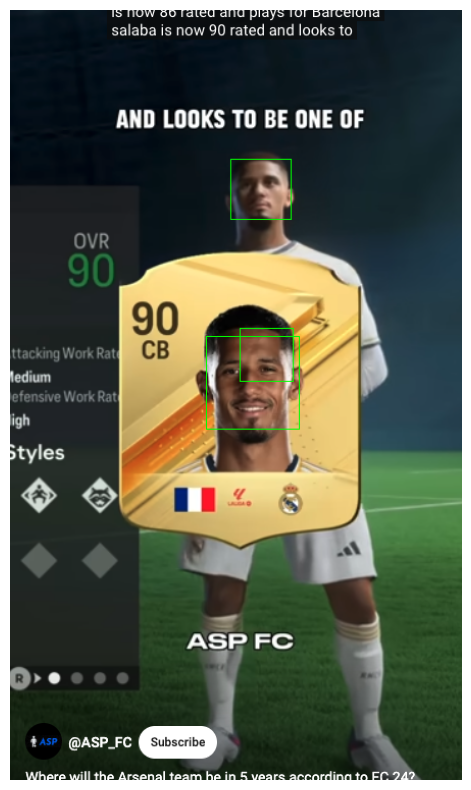

In [45]:
face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_alt2.xml')
frame = cv2.imread('samples/sample_3.png')
faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)

# convert image for pyplot
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# show image
plt.figure(figsize=(20,10))
plt.imshow(frame_rgb)
plt.axis('off')

angle: 0, faces: [[212 196 123 123]]
angle: 0, faces: [[212 196 123 123]], detected_faces: {0: [(212, 196, 123, 123)]}, best_angle: 0
angle: 90, faces: ()
angle: 90, faces: (), detected_faces: {0: [(212, 196, 123, 123)]}, best_angle: 0
angle: 270, faces: ()
angle: 270, faces: (), detected_faces: {0: [(212, 196, 123, 123)]}, best_angle: 0


(-0.5, 631.5, 1145.5, -0.5)

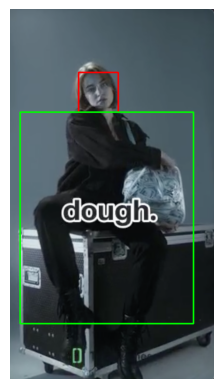

In [24]:
face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')
frame = cv2.imread('samples/sample_7.png')

best_angle = 0
most_faces_detected = 1

orientation_counter = FaceOrientationCounter()
orientation_counter.update(best_angle, most_faces_detected)

frame = frame_checker(face_cascade, frame, orientation_counter)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# show image
plt.imshow(frame_rgb)
plt.axis('off')

In [12]:
face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')
frame = cv2.imread('samples/sample_6_90.png')

best_angle = 90
most_faces_detected = 1

orientation_counter = FaceOrientationCounter()
orientation_counter.update(best_angle, most_faces_detected)

detect_faces_in_rotations_3(frame, face_cascade, orientation_counter)

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 189  515  252  252]
 [  93  943   58   58]
 [ 592 1085  148  148]
 [ 120 1102  128  128]
 [ 322 1064  164  164]], detected_faces: {90: [(189, 515, 252, 252), (93, 943, 58, 58), (592, 1085, 148, 148), (120, 1102, 128, 128), (322, 1064, 164, 164)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(189, 515, 252, 252), (93, 943, 58, 58), (592, 1085, 148, 148), (120, 1102, 128, 128), (322, 1064, 164, 164)]}, best_angle: 90


[(861, 189, 252, 252),
 (627, 93, 58, 58),
 (395, 592, 148, 148),
 (398, 120, 128, 128),
 (400, 322, 164, 164)]

In [13]:
frame = cv2.imread('samples/sample_6_270.png')

rotation_angles = [0, 90, 270]

most_faces_detected = 0
best_angle = 0

dic = dict()

for angle in rotation_angles:
    # Rotate the image
    rotated_frame, M = rotate_image(frame, angle)

    # Detect faces
    faces = face_cascade.detectMultiScale(rotated_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    adjusted_faces = []
    if most_faces_detected > 0:
        for (x, y, w, h) in detected_faces:
            # Calculate the inverse rotation for the detected face coordinates based on the best angle
            rotated_frame, M = rotate_image(frame, best_angle)
            inv_M = cv2.invertAffineTransform(M)
            original_coords = np.array([[x + w/2, y + h/2]], dtype=np.float32)
            original_coords = np.array([original_coords])
            # Transform back the coordinates of the center of the face
            transformed_coords = cv2.transform(original_coords, inv_M)
            ox, oy = transformed_coords[0][0]
            ox, oy = int(ox - w/2), int(oy - h/2)
            
            # Store the corrected face box
            adjusted_faces.append((ox, oy, w, h))
        
    dic[angle] = faces

# # show image
# plt.imshow(rotated_frame)
# plt.axis('off')

In [14]:
face_cascade = cv2.CascadeClassifier('model/haarcascade_frontalface_default.xml')
frame = cv2.imread('samples/sample_6_90.png')

best_angle = 90
most_faces_detected = 1

orientation_counter = FaceOrientationCounter()
orientation_counter.update(best_angle, most_faces_detected)

detect_faces_in_rotations_3(frame, face_cascade, orientation_counter)

angle: 0, faces: (), detected_faces: {}, best_angle: 0
angle: 90, faces: [[ 189  515  252  252]
 [  93  943   58   58]
 [ 322 1064  164  164]
 [ 592 1085  148  148]
 [ 120 1102  128  128]], detected_faces: {90: [(189, 515, 252, 252), (93, 943, 58, 58), (322, 1064, 164, 164), (592, 1085, 148, 148), (120, 1102, 128, 128)]}, best_angle: 90
angle: 270, faces: (), detected_faces: {90: [(189, 515, 252, 252), (93, 943, 58, 58), (322, 1064, 164, 164), (592, 1085, 148, 148), (120, 1102, 128, 128)]}, best_angle: 90


[(861, 189, 252, 252),
 (627, 93, 58, 58),
 (400, 322, 164, 164),
 (395, 592, 148, 148),
 (398, 120, 128, 128)]

In [187]:
dic

{0: array([[ 670,  428,  129,  129],
        [1181,  662,   61,   61]], dtype=int32),
 90: (),
 270: array([[ 278,  440,   56,   56],
        [ 190,  512,  246,  246],
        [  92,  940,   61,   61],
        [ 324, 1065,  160,  160],
        [ 593, 1085,  146,  146],
        [ 122, 1104,  125,  125]], dtype=int32)}